# Tuning and Pipeline Tutorial

In [1]:
# basics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# machine learning
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

## The "Long Way" with a Single Validation Set

In [2]:
# simulate data
X, y = make_friedman1(
    n_samples=1000,
    n_features=10,
    noise=1.0,
    random_state=42,
)

In [3]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_vtrain, X_val, y_vtrain, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [4]:
# check the shapes of the train data
X_train.shape, y_train.shape

((800, 10), (800,))

In [5]:
# check the shapes of the validation-train data
X_vtrain.shape, y_vtrain.shape

((640, 10), (640,))

In [6]:
# define range of k values to search over
k_values = range(1, 102, 2)

In [7]:
# initialize storage for train RMSE values
# FOR ILLUSTRATIVE PURPOSES ONLY
train_rmse = []

# initialize storage for validation RMSE values
validation_rmse = []

In [8]:
# fit models and calculate validation RMSE for each value of k
for k in k_values:

    # initialize model, with the current k
    knn = KNeighborsRegressor(n_neighbors=k)

    # fit the model to the (validation) train data
    knn.fit(X_vtrain, y_vtrain)

    # get train predictions
    # FOR ILLUSTRATIVE PURPOSES ONLY
    y_train_pred = knn.predict(X_train)

    # calculate (and store) train RMSE
    # FOR ILLUSTRATIVE PURPOSES ONLY
    rmse_train = root_mean_squared_error(y_train, y_train_pred)
    train_rmse.append(rmse_train)

    # get validation predictions
    y_val_pred = knn.predict(X_val)

    # calculate (and store) validation RMSE
    rmse_val = root_mean_squared_error(y_val, y_val_pred)
    validation_rmse.append(rmse_val)

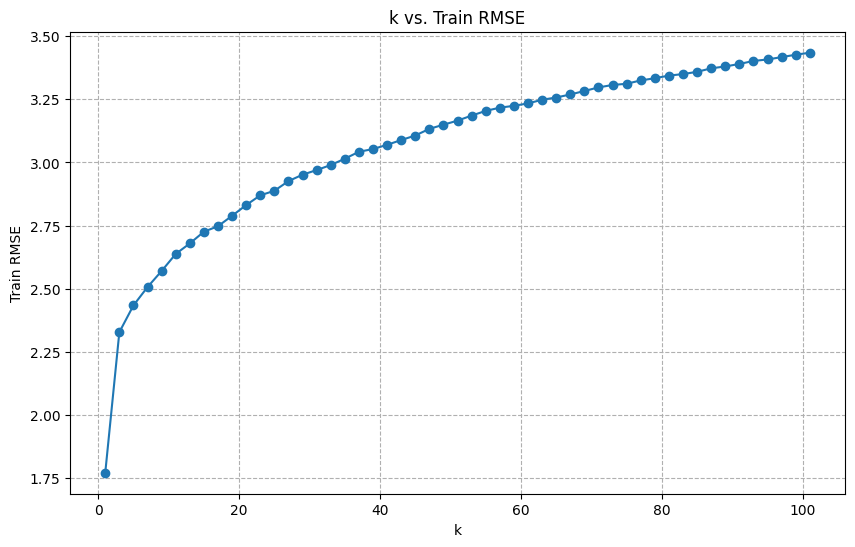

In [9]:
# plot train RMSE against k
# FOR ILLUSTRATIVE PURPOSES ONLY
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(k_values, train_rmse, marker="o")
ax.set_xlabel("k")
ax.set_ylabel("Train RMSE")
ax.set_title("k vs. Train RMSE")
ax.grid(True, linestyle="--")
plt.show()

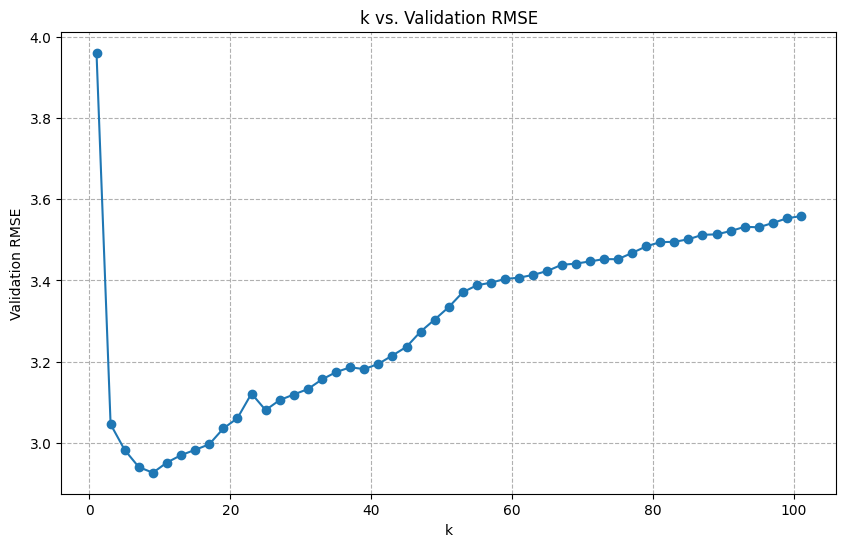

In [10]:
# plot validation RMSE against k
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(k_values, validation_rmse, marker="o")
ax.set_xlabel("k")
ax.set_ylabel("Validation RMSE")
ax.set_title("k vs. Validation RMSE")
ax.grid(True, linestyle="--")
plt.show()

In [11]:
# find the best k based on validation procedure
best_k = k_values[np.argmin(validation_rmse)]
best_val_rmse = validation_rmse[np.argmin(validation_rmse)]
print(f"Best k: {best_k}")
print(f"Validation RMSE for k = {best_k}: {best_val_rmse}")

Best k: 9
Validation RMSE for k = 9: 2.92615334507489


In [12]:
# fit a final model with chosen value of k to (full) train data
knn_final = KNeighborsRegressor(n_neighbors=best_k)
_ = knn_final.fit(X_train, y_train)

In [13]:
# quantify performance of final model with the test data
y_test_pred = knn_final.predict(X_test)
test_rmse = root_mean_squared_error(y_test, y_test_pred)
print(f"Test RMSE: {test_rmse}")

Test RMSE: 2.645034473417418


## The `sklean` Pipeline Way with Cross-Validation

In [14]:
# helper function to simulate classification data
def simulate_classification_data(n_samples=100, seed=42):
    np.random.seed(seed)
    numeric_features = pd.DataFrame(
        {
            "num1": 100 * np.random.randn(n_samples),
            "num2": np.random.randn(n_samples),
        }
    )
    categorical_features = pd.DataFrame(
        {
            "cat1": np.random.choice(["A", "B", "C"], size=n_samples),
            "cat2": np.random.choice(["X", "Y", "Z"], size=n_samples),
        }
    )
    # note that we are simulating the target without any dependency on the features
    # so a "good" model won't do much of anything here
    # the baseline "dummy" model will be about as good as possible
    target = pd.Series(np.random.choice([0, 1], size=n_samples), name="target")
    df = pd.concat([numeric_features, categorical_features, target], axis=1)
    df.loc[df.sample(frac=0.1).index, "num1"] = np.nan
    df.loc[df.sample(frac=0.2).index, "cat1"] = np.nan
    return df

In [15]:
# simulate data
sim_data = simulate_classification_data(n_samples=1000)

In [16]:
# train-test split the data
sim_train, sim_test = train_test_split(sim_data, test_size=0.2, random_state=42)

In [17]:
# create the X and y version of the data
X_train = sim_train.drop("target", axis=1)
y_train = sim_train["target"]
X_test = sim_test.drop("target", axis=1)
y_test = sim_test["target"]

In [18]:
# check shapes of data
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((800, 4), (800,), (200, 4), (200,))

In [19]:
# note numeric and categorical features
numeric_features = ["num1", "num2"]
categorical_features = ["cat1", "cat2"]

# define preprocessing for numeric features
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
    ]
)

# define preprocessing for categorical features
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder()),
    ]
)

# combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# create pipeline, preprocess then classify
pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", KNeighborsClassifier()),
    ]
)

In [20]:
pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['num1', 'num2']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['cat1', 'cat2'])])),
                ('classifier', KNeighborsClassifier())])

In [21]:
# define parameter grid
param_grid = {
    "preprocessor__cat__onehot__drop": [None, "first"],
    "preprocessor__num__scaler": [None, StandardScaler()],
    "classifier__n_neighbors": [3, 5, 7, 9, 11],
    "classifier__metric": ["euclidean", "manhattan"],
}

In [22]:
# setup grid search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring="accuracy")

In [23]:
# run grid search with cross-validation
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['num1',
                                                                          'num2']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder())]),
                                                                         ['cat1',
                                                                          'cat2'])])),
                                       ('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__metric': ['euclidean', 'manhattan'],
                         'classifier__n_neighbors': [3, 5, 7, 9, 11],
                         'preprocessor__cat__onehot__drop': [None, 'first'],
                         'preprocessor__num__scaler': [None, StandardScaler()]},
             scoring='accuracy')

In [24]:
# print best parameters found and best (cross-validated) score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_}")

Best parameters: {'classifier__metric': 'manhattan', 'classifier__n_neighbors': 7, 'preprocessor__cat__onehot__drop': 'first', 'preprocessor__num__scaler': StandardScaler()}
Best cross-validation accuracy: 0.54


In [25]:
# final evaluation on test set
# note that the model is stored in the grid_search
# and is auto-magically refit to the full train data
y_pred = grid_search.predict(X_test)
print(f"Test set accuracy: {accuracy_score(y_test, y_pred)}")

Test set accuracy: 0.545


In [26]:
# grid search results (messy)
grid_search.cv_results_

{'mean_fit_time': array([0.00381603, 0.00321689, 0.00313787, 0.00328794, 0.00274277,
        0.00303884, 0.00764661, 0.00297728, 0.00282907, 0.00288463,
        0.00293541, 0.00314908, 0.00972071, 0.00314288, 0.00338879,
        0.00359969, 0.0033246 , 0.00325718, 0.00344901, 0.00342674,
        0.00307803, 0.00318456, 0.00310211, 0.00299826, 0.00278411,
        0.00292382, 0.00282965, 0.00294833, 0.00281625, 0.0028574 ,
        0.00281944, 0.00295882, 0.00270367, 0.0030406 , 0.00271959,
        0.00302677, 0.00274911, 0.00293903, 0.00270028, 0.00288534]),
 'std_fit_time': array([6.79512151e-04, 2.10862794e-04, 2.23253681e-04, 3.09988554e-04,
        1.91258784e-04, 1.18856231e-04, 8.81191338e-03, 1.65557394e-04,
        2.30090506e-04, 9.32960872e-05, 2.31750855e-04, 2.78986309e-04,
        1.37684713e-02, 1.80555157e-04, 4.64525611e-04, 3.13197499e-04,
        2.29418325e-04, 3.07460429e-04, 3.40844468e-04, 2.48928243e-04,
        3.06587656e-04, 3.32360220e-04, 1.25511058e-04, 1.678

In [27]:
# convert cv_results_ to a pandas DataFrame
cv_results_df = pd.DataFrame(grid_search.cv_results_)

# select relevant columns for better readability
cv_results_df = cv_results_df[
    [
        "param_preprocessor__cat__onehot__drop",
        "param_classifier__n_neighbors",
        "param_classifier__metric",
        "mean_test_score",
        "std_test_score",
        "rank_test_score",
    ]
]

# sort by rank_test_score for better readability
cv_results_df = cv_results_df  # .sort_values(by='rank_test_score')

# display the df
cv_results_df

,param_preprocessor__cat__onehot__drop,param_classifier__n_neighbors,param_classifier__metric,mean_test_score,std_test_score,rank_test_score
0,None,3,euclidean,0.46875,0.033072,38
1,None,3,euclidean,0.50875,0.009354,17
2,first,3,euclidean,0.49125,0.048186,21
3,first,3,euclidean,0.51375,0.015512,15
4,None,5,euclidean,0.47625,0.033166,29
5,None,5,euclidean,0.50125,0.010753,20
6,first,5,euclidean,0.49125,0.032259,21
7,first,5,euclidean,0.50250,0.010897,19
8,None,7,euclidean,0.47750,0.044826,28
9,None,7,euclidean,0.51625,0.023251,13
